<a href="https://colab.research.google.com/github/lel-nh/DataProject/blob/main/Mushroom_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will describe our research process to best classify different mushroom images and help prevent users picking poisonous species. To train our model we will use the dataset found at https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images/data.

In [4]:
#Imports

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive
from IPython.display import Image, display
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First let's import our dataset and prepare it for our model to train.
We have loaded all the images on a shared google drive folder : Mushroom. As our images come in different shapes and sizes, we will resize them so that they share the same dimensions.
First we create the Resized folder:

In [5]:
os.getcwd()
os.chdir('/content/drive/MyDrive/Mushroom/')
os.mkdir('Resized')

FileExistsError: ignored

Then, we fill it with the same subfolders as the original dataset:

In [6]:
os.chdir('Resized')
# Navigate to the desired folder
dataset = '/content/drive/MyDrive/Mushroom/Mushrooms'
resized = '/content/drive/MyDrive/Mushroom/Resized'

# Create folders in resize folder
for subfolder in os.listdir(dataset):
  os.mkdir(f'{subfolder}')

FileExistsError: ignored

In order to respect the original size of the images, we have decided that the common dimensions should be the mean width and height.

In [7]:
# Get mean size of images in dataset
nb, width, height = 0, 0, 0
for subfolder in os.listdir(dataset):
  path = f'{dataset}/{subfolder}'
  for image in os.listdir(path):
    image_path = f'{path}/{image}'
    with Image.open(image_path) as img:
      width=width+img.width
      height=height+img.height
      nb=nb+1
      mean_width = width//nb
      mean_height = height//nb
target_size = (mean_width, mean_height)
print(target_size)


(796, 579)


Our last step is to fill the "Resized"'s subfolders with the resized images.

In [8]:
def resize_image(input_path, output_path, new_size):
    try:
        # Open the image
        with Image.open(input_path) as img:
            # Resize the image
            resized_img = img.resize(new_size)

            # Save the resized image
            resized_img.save(output_path)
    except Exception as e:
        print(f"Error: {e}")

def populate(origin, destination):

  for subfolder in os.listdir(origin):
    input_path = f'{origin}/{subfolder}'
    output_path = f'{destination}/{subfolder}'
    for image in os.listdir(input_path):
      input_image_path = f'{input_path}/{image}'
      output_image_path = f'{output_path}/{image}'
      resize_image(input_image_path, output_image_path, target_size)

populate(dataset,resized)

KeyboardInterrupt: ignored

Now let's have a better look at our dataset and at our different species. We have nine families that we can briefly visualise by taking a sample image out of each.

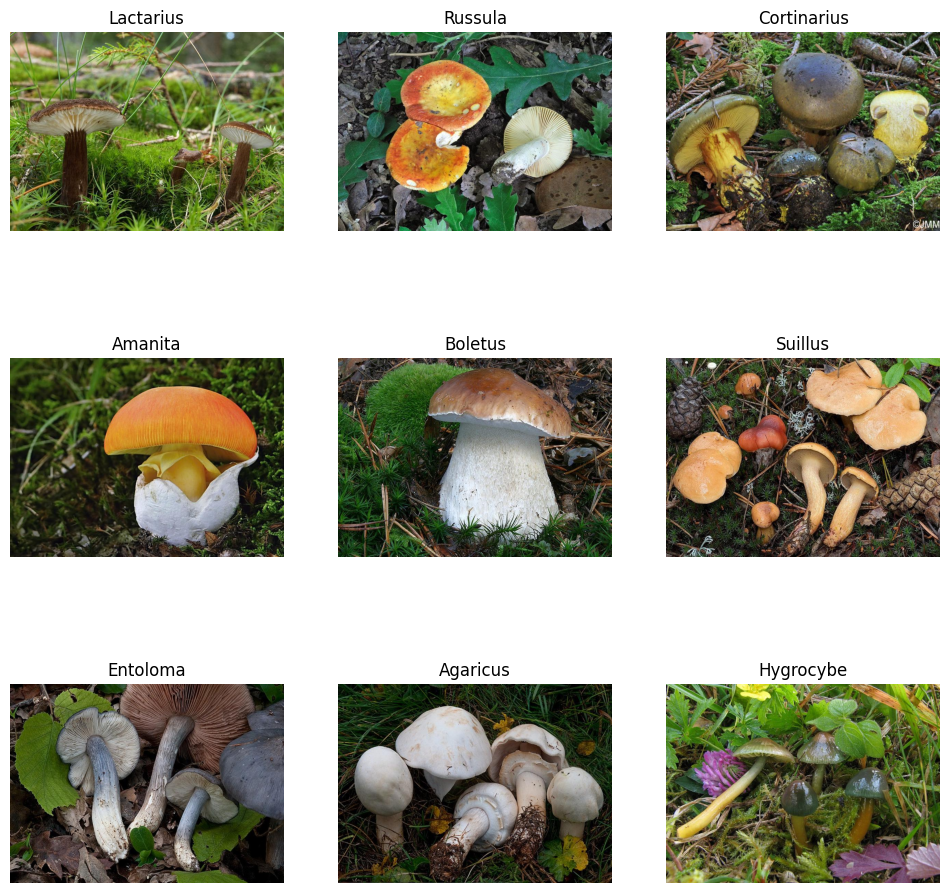

In [9]:
nrows = 3
ncols = 3

pos = 0

for subfolder in os.listdir(resized):

    image_file = os.listdir(os.path.join(resized, subfolder))[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(resized, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

Now that we know more about them, we can start separating our data into two different categories : training and validation.

In [10]:
batch_size = 49

train_ds = tf.keras.utils.image_dataset_from_directory(
  resized,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

Found 6713 files belonging to 9 classes.
Using 5371 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  resized,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=target_size,
  batch_size=batch_size)

Found 6713 files belonging to 9 classes.
Using 1342 files for validation.


We can now create a model that will strart its training to classify the data into our 9 classes. Our model will have 6 layers (3 convolutional and 3 MaxPooling), one flatenning layer and one fully connected layer.

In [15]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(796, 579, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation='relu'),
  layers.Dense(num_classes)
])

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


Once the model is created, we can compile it using the adam optimizer.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 796, 579, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 796, 579, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 398, 289, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 398, 289, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 199, 144, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 199, 144, 64)     

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
 72/110 [==================>...........] - ETA: 17:05 - loss: 2.3306 - accuracy: 0.2205